<a href="https://colab.research.google.com/github/smanfri/AFMD_2022/blob/main/2022_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FINDING SIMILAR ITEMS
##Ukraine Conflict Twitter Dataset 

#Set up the environment

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://archive.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init("spark-2.4.8-bin-hadoop2.7") 
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()

spark = SparkSession.builder \
    .master('local[*]') \
    .config('spark.executor.memory', '5G') \
    .config("spark.driver.memory", "5g") \
    .appName('my-cool-app') \
    .getOrCreate()

sc = spark.sparkContext

--2022-07-06 14:02:09--  https://archive.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  23.6MB/s    in 21s     

2022-07-06 14:02:31 (10.7 MB/s) - ‘spark-2.4.8-bin-hadoop2.7.tgz’ saved [235899716/235899716]



#Importing the libraries needed

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import csv
import os
import re
import random
import matplotlib.pyplot as plt

#Connect with kaggle

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


#Download the data
Specify the number of files that we want to download.
Filter for only tweet in english and mantain only the columns tweetId and text of the tweet.

In [ ]:
result = !kaggle datasets files -v bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows
result = result[1:] #Filtering the header.
list_files = [r.split(',')[0] for r in result]
print(list_files)

['0508_UkraineCombinedTweetsDeduped.csv.gzip', '0426_UkraineCombinedTweetsDeduped.csv.gzip', '0430_UkraineCombinedTweetsDeduped.csv.gzip', '0503_UkraineCombinedTweetsDeduped.csv.gzip', '0403_UkraineCombinedTweetsDeduped.csv.gzip', '0415_UkraineCombinedTweetsDeduped.csv.gzip', '0511_UkraineCombinedTweetsDeduped.csv.gzip', '0422_UkraineCombinedTweetsDeduped.csv.gzip', '0423_UkraineCombinedTweetsDeduped.csv.gzip', '0407_UkraineCombinedTweetsDeduped.csv.gzip', '0505_to_0507_UkraineCombinedTweetsDeduped.csv.gzip', '0417_UkraineCombinedTweetsDeduped.csv.gzip', '0412_UkraineCombinedTweetsDeduped.csv.gzip', '0515_UkraineCombinedTweetsDeduped.csv.gzip', '0414_UkraineCombinedTweetsDeduped.csv.gzip', '0418_UkraineCombinedTweetsDeduped.csv.gzip', '0406_UkraineCombinedTweetsDeduped.csv.gzip', '0502_UkraineCombinedTweetsDeduped.csv.gzip', '0402_UkraineCombinedTweetsDeduped.csv.gzip', '0419_UkraineCombinedTweetsDeduped.csv.gzip', '0518_UkraineCombinedTweetsDeduped.csv.gzip', '0413_UkraineCombinedTwee

In [ ]:
def foundFileAvailable(list_filesName:list):
  """Function that found the first file available for the download
     in the list of file names.
    
    Parameters
    --------------------------
    list_filesName:list
        The list of file names.

    Raises
    ---------------------
    ValueError,
        If the list is empty.
    
    Returns
    ---------------------
    path_file:str,
        The path file of the first file found available for the download.
    list_filesName:list
        The rest of the list not already checked.    
  """
  
  len_list = len(list_filesName)
  if len_list == 0:
    raise ValueError('The list is empty.')
  numFileAlreadyScan = 0
  for i in range(len_list):
    path_file = list_filesName[i]
    result = !kaggle datasets download bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows -f {path_file}
    if result[0] != '404 - Not Found':
      numFileAlreadyScan = i
      break
  return path_file, list_filesName[numFileAlreadyScan+1:]

In [ ]:
def getRDD(list_filesName:list, numberToDownload:int):
  """Function that return the RDD composed of the data from the file downloaded.
     Only the tweets in English are maintened.
    
    Parameters
    --------------------------
    list_filesName:list,
        The list of file names.
    numberToDownload:int
        Number of files to be downloaded.

    Raises
    ---------------------
    ValueError,
        If the list is empty.
    
    Returns
    ---------------------
    RDD_Tweets: RDD
        RDD that contains the data downloaded.
  """
  RDD_Tweets = sc.emptyRDD()
  for i in range(numberToDownload):
    path_file, list_filesName = foundFileAvailable(list_filesName)
    content_path = "/content/"+path_file

    !kaggle datasets download bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows -f {path_file}
    !unzip {content_path} -d "/content/"
    df = pd.read_csv(content_path, compression='gzip', index_col=0,encoding='utf-8', quoting=csv.QUOTE_ALL)

    #select only the tweets in english
    df_en=df[df['language']=='en'][['tweetid', 'text']]
    RDD_New = spark.createDataFrame(df_en).rdd
    RDD_Tweets = RDD_Tweets.union(RDD_New)
  return RDD_Tweets

In [ ]:
RDD_Tweets = getRDD(list_files, numberToDownload=1)
RDD_Tweets.count()

0403_UkraineCombinedTweetsDeduped.csv.gzip.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/0403_UkraineCombinedTweetsDeduped.csv.gzip.zip
  inflating: /content/0403_UkraineCombinedTweetsDeduped.csv.gzip  


298604

Calculate the best value for the bands and the rows given the total number of hash function willing to use and the threshold.

#Setting the Parameters

In [ ]:
def isInteger(val:float):
  truncated = int(val)
  return truncated == val

In [ ]:
k = 5
TotNumberHashFunction = 100
ThresholdValue = 0.7


Bs = list(range(1, TotNumberHashFunction))
Rs = [(TotNumberHashFunction/b) for b in Bs]
Integer_Bs = []
Integer_Rs = []
for i in range(len(Bs)):
  if isInteger(Bs[i]) and isInteger(Rs[i]):
    Integer_Bs.append(Bs[i])
    Integer_Rs.append(int(Rs[i]))
Ss = []
for i in range(len(Integer_Bs)):
  OneOverB = (1/Integer_Bs[i])
  OneOverR = (1/Integer_Rs[i])
  Ss.append(OneOverB**OneOverR)
MinDifference = [np.abs(s-ThresholdValue) for s in Ss]
bands = [b for _, b in sorted(zip(MinDifference, Integer_Bs))][0]
rows = [r for _, r in sorted(zip(MinDifference, Integer_Rs))][0]
print(f'The number of bands is {bands}, and the number of rows per band is {rows}')

The number of bands is 10, and the number of rows per band is 10


#Text Cleaning

In [ ]:
def cleanText(text:str):
  """Returns the text cleaned if its length after cleaning is at least 5 characters,
  otherwise returns 0.
    
    Parameters
    --------------------------
    text:str
        The text to be cleaned.
    """
  text = text.lower()
  text =  re.sub('\n|\"|\'', '', text)
  text = re.sub('[^a-z#@ ]+', '', text)
  text =  re.sub('^\s+|\s+$|\s+(?=\s)', '', text)
  if len(text) > 5:
    return text
  else:
    return 0

In [ ]:
RDD_TweetsCleaned = RDD_Tweets.map(lambda x: (x[0], cleanText(x[1])))\
                               .filter(lambda x: x[1] != 0)
NumberOfTweets = RDD_TweetsCleaned.count()
print(NumberOfTweets)

298604


#Get only one rapresentative for identical tweets

In [ ]:
def hash_polinomialRolling(text: str):
  """Returns the string hashed using the algorithm polinomial rolling.
    
    Parameters
    --------------------------
    text:str
        The text to be hashed.
    """
  p, m = 31, 2**32 -1 
  length = len(text)
  hash_value = 0
  p_pow = 1
  for i in range(length):
      hash_value = (hash_value + (1 + ord(text[i]) - ord('a')) * p_pow) % m
      p_pow = (p_pow * p) % m
  return hash_value


def kShingleNoHash(text:str, k:int)->list:
  """Returns the list of k-shingles contained in the string.
    
    Parameters
    --------------------------
    text:str,
        The text from which extract the shingles.
    k:int
        The lenght of the shingles.
    """
  listOfShingle = []
  for i in range(0, len(text)-(k-1)):
    substring = text[i: i+k]
    listOfShingle.append(substring.lower())
  return list(set(listOfShingle))

def kShinglePlusHash(text:str, k:int)->list:
  """Returns the list of hashed k-shingles contained in the string.
    
    Parameters
    --------------------------
    text:str,
        The text from which extract the shingles.
    k:int
        The lenght of the shingles.
    """
  listOfShingle = []
  for i in range(0, len(text)-(k-1)):
    substring = text[i: i+k]
    hashedSubstring = hash_polinomialRolling(substring.lower())
    listOfShingle.append(hashedSubstring)
  return list(set(listOfShingle))

  
def hashText(text:str):
  """Returns the polinomial rolling hash of the text.
    
    Parameters
    --------------------------
    text:str,
        The text to be hashed.
    """
  return hash_polinomialRolling(text.lower())


def checkPrime(num:int)->bool:
  """Function that check if a integer number is a prime number.
    
    Parameters
    --------------------------
    num:int
        The number to be checked.

    Raises
    ---------------------
    ValueError,
        If the number passes as parameter is <= 0.
    
    Returns
    ---------------------
    If the number passed as argument is prime --> True
    If the number passed as argument is not prime --> False

    
  """
  if num <= 0:
    raise ValueError('The number passes as parameter must be > 0.')
  else:
    isPrime = True      
    if num > 1:
    # Iterate from 2 to n / 2
      for i in range(2, int(num/2)+1):
          # If num is divisible by any number between
          # 2 and n / 2, it is not prime
          if (num % i) == 0:
              #print(num, "is not a prime number")
              isPrime = False
              break
    return isPrime

  
def firstPrimeNumberBigger(num:int)->int:
  """Function that calculates the first prime bigger than 
     the number passed as argument.
    
    Parameters
    --------------------------
    num:int
        The number from which search the prime number.

    Raises
    ---------------------
    ValueError,
        If the number passes as parameter is <= 0.
    
    Returns
    ---------------------
    The first prime bigger than the number passed as argument.

    
  """
  findPrime = False
  while findPrime != True:
    findPrime = checkPrime(num)
    if findPrime:
      return num
    else:
      num += 1

In [ ]:
RDD_UniqueTweets = RDD_TweetsCleaned.map(lambda x: (hashText(x[1]), x[0]))\
                                    .reduceByKey(lambda x, y: x if x < y else y)


#Create the test set

In [ ]:
def removeMentions(text:str)->str:
  """Function that removes the mentions from the text.
    
    Parameters
    --------------------------
    text:str
        The text from which remove the mentions.

    
    Returns
    ---------------------
    The text without the mentions.

    
  """
  text = text.lower()
  text =  re.sub('\n|\"|\'', ' ', text)
  text = re.sub('[^a-z#@ ]+', '', text)
 
  firstOccurrence = text.find('@')
  while firstOccurrence != -1:
    match_start = firstOccurrence
    textTillEnd = text[match_start+1:]
    firstOccurrenceSpace = textTillEnd.find(' ')
    firstOcurrenceHashtag = textTillEnd.find('#')
    firstOcurrenceAt = textTillEnd.find('@')
    EndOfSubString = len(textTillEnd)
    if firstOccurrenceSpace == -1:
      firstOccurrenceSpace = len(textTillEnd)
    if firstOcurrenceHashtag == -1:
      firstOcurrenceHashtag = len(textTillEnd)
    if firstOcurrenceAt == -1:
      firstOcurrenceAt = len(textTillEnd)
    endOfLink = min(firstOccurrenceSpace, firstOcurrenceHashtag, firstOcurrenceAt, EndOfSubString)
    text = text[:match_start] + text[match_start+endOfLink+1:]
    firstOccurrence = text.find('@')
  text =  re.sub('^\s+|\s+$|\s+(?=\s)', '', text)
  if len(text) > 5:
    return text
  else:
    return 0

In [ ]:
RDD_UniqueTweetsInverted = RDD_UniqueTweets.map(lambda x: (x[1], x[0]))
RDD_JoinWithText = RDD_UniqueTweetsInverted.leftOuterJoin(RDD_TweetsCleaned)
RDD_HashWithAndWithoutMentions = RDD_JoinWithText.map(lambda x: (hashText(removeMentions(x[1][1])), x[0]))
RDD_TestSet = RDD_HashWithAndWithoutMentions.join(RDD_HashWithAndWithoutMentions)\
                                          .filter(lambda x: x[1][0] < x[1][1])\
                                          .map(lambda x: x[1])

#Filter out all the identical tweets
Maintain only one representative for identical tweets.

In [ ]:
RDD_UniqueTweetsText = RDD_UniqueTweets.map(lambda x: (x[1], 1))\
                                     .leftOuterJoin(RDD_TweetsCleaned)

#k-Shingle Hashed
Dividing the document in shingles, hashing them and get the number of distict shingles in the entire dataset.

In [ ]:
RDD_ShinglesHashed = RDD_UniqueTweetsText.map(lambda x: (x[0], kShinglePlusHash(x[1][1], k)))
RDD_ShingleHashed = RDD_ShinglesHashed.flatMap(lambda x: [(x[0], x[1][t]) for t in range(len(x[1]))])


##Number of Distinct k-Shingles

In [ ]:
RDD_ShingleHashedDistinct = RDD_ShingleHashed.map(lambda x: x[1]).distinct()
NumHashedShingles = RDD_ShingleHashedDistinct.count()
NumHashedShingles

630627

#Creation Of The Min-Hash Functions

In [ ]:
def getParamenters(numPartitions:int, TotSignatures:int, NumHashedShingles:int):
  """Function that creates TotSignatures min-hash functions.
    
    Parameters
    --------------------------
    numPartitions:int, 
        The number of bands.
    TotSignatures:int,
        The number of min-hash functions.
    NumHashedShingles:int
        The number of distinct shingles presents in the dataset.
    
    Returns
    ---------------------
    dict_hashFunctionParam
        Dictionary that contains the parameter of the min-hash functions.
    p
        The prime number used to create the min-hash values.

    
  """
  m = (int(NumHashedShingles/numPartitions))+1
  p = firstPrimeNumberBigger(m)
  numHashFunctions = (int(TotSignatures/numPartitions))
  dict_hashFunctionParam = {}
  for i in range(0, numHashFunctions):
    a = random.randint(1, p-1)
    b = random.randint(0, p-1)
    dict_hashFunctionParam[i] = [a, b]
  return dict_hashFunctionParam, p

#Imposting the number of bands and the number of min-hash functions

In [ ]:
bands=bands
numPartitions=bands
TotSignatures=TotNumberHashFunction
dict_hashFunctionParam, p = getParamenters(numPartitions=bands, TotSignatures=TotSignatures, NumHashedShingles=NumHashedShingles)
dictMinHashFuncBr = sc.broadcast(dict_hashFunctionParam)

#Creation of the Min-Hash Values

In [ ]:
def getSignatureMatrix(DocIDHashedShingle, dictMinHashFunctions:dict, p:int):
  """Function that identify the bands to which the hashedShingle belongs
     and create its min-hash values.
    
    Parameters
    --------------------------
    DocIDHashedShingle:Tuple[int, int],
        A tuple containing the DocId and the hashedShingle.
    dictMinHashFunctions:dict,
        The dictionary contains the parameters of the min-hash functions.
    p:int
        The prime number used for the calculus of the min-hash functions.
    
    Returns
    ---------------------
    Tuple[(int, int), list],
        A tuple containing the DocID, the band number and the list of the
        min-hash values.
    
  """
  list_minHashValues = []
  DocID = DocIDHashedShingle[0]
  hashedShingle = DocIDHashedShingle[1]
  module = hashedShingle % numPartitions
  for key, value in dictMinHashFunctions.items():
    list_ab = value
    minHashValue = (list_ab[0] * hashedShingle + list_ab[1]) % p 
    list_minHashValues.append(minHashValue)
  return ((DocID, module), list_minHashValues)


RDD_ShingleHashed_SMValues = RDD_ShingleHashed.map(lambda x: getSignatureMatrix(x, dictMinHashFuncBr.value, p))

In [ ]:
RDD_ShingleHashed_SMValues.count()

10909966

In [ ]:
def reduceCustom(List_minHashValues1, List_minHashValues2):
  """Function that obtains the minumum value for each min-hash value.
    
    Parameters
    --------------------------
    List_minHashValues1,
        List of min-hash values.
    DocidModuleList_minHashValues2
        List of min-hash values.
    
    Returns
    ---------------------
    list_result
        List containing the minimum value for each min-hash value.
    
  """
  list_result = []
  for k in range(len(List_minHashValues1)):
    list_result.append(min(List_minHashValues1[k], List_minHashValues2[k]))
  return list_result


RDD_ShingleHashed_MinSMValues = RDD_ShingleHashed_SMValues.reduceByKey(lambda x, y: reduceCustom(x,y))

#Hashing The Bands

In [ ]:
def LSH(list_minHashValues)->int:
  """Function that takes a list of integer value, convert it to a string
     and hash it with the polinomial rolling function.
    
    Parameters
    --------------------------
    list_minHashValues,
        List of min-hash values.
    
    Returns
    ---------------------
    int
        Hashed value.
    
  """
  str_tot = ''
  for l in list_minHashValues:
    str_tot += str(l)
  return hash_polinomialRolling(str_tot)


RDD_ShingleHashed_LSH = RDD_ShingleHashed_MinSMValues.map(lambda x: ((x[0][1], LSH(x[1])),x[0][0]))

#The Candidate Pairs

In [ ]:
RDD_ModuleLSH = RDD_ShingleHashed_LSH.join(RDD_ShingleHashed_LSH)\
                                     .filter(lambda x: x[1][0] < x[1][1])\
                                     .map(lambda x: (x[1], 1))
RDD_ModuleLSHUnique = RDD_ModuleLSH.reduceByKey(lambda x, y: x+y)

In [ ]:
RDD_CandidatePairsUnique = RDD_ModuleLSHUnique.map(lambda x: x[0])
RDD_CandidatePairsUnique.count()

172261

#True Positive

In [ ]:
RDD_CpBody = RDD_CandidatePairsUnique.leftOuterJoin(RDD_TweetsCleaned)

In [ ]:
RDD_CpBody = RDD_CpBody.map(lambda x: (x[1][0], (x[0], x[1][1])))

In [ ]:
RDD_CpBodyDoubleJoin = RDD_CpBody.leftOuterJoin(RDD_TweetsCleaned)

In [ ]:
RDD_CpBodyDoubleJoin = RDD_CpBodyDoubleJoin.map(lambda x: ((x[1][0][0], x[0]), (x[1][0][1], x[1][1])))

In [ ]:
def getJS(pair):
  """Function that calculates the Jaccard Similarity between two documents
     represented as set of hashed k-shingles.
    
    Parameters
    --------------------------
    pair
        Variable that contains ((docId1, docID2), (doc1Body, doc2Body))
    
    Returns
    ---------------------
    result
        Variable that contains ((doc1Id, doc2Id), (doc1Body, doc2Body), JS(doc1, doc2))
    
  """
  doc1Id = pair[0][0]
  doc2Id = pair[0][1]
  doc1Body = pair[1][0]
  doc2Body = pair[1][1]
  doc1Shingles = kShinglePlusHash(doc1Body, 5)
  doc2Shingles = kShinglePlusHash(doc2Body, 5)
  intersection = [value for value in doc1Shingles if value in doc2Shingles]
  union = doc1Shingles + doc2Shingles
  return ((doc1Id, doc2Id), (doc1Body, doc2Body), len(list(set(intersection)))/len(list(set(union))))

In [ ]:
RDD_CpTrueSimilarity = RDD_CpBodyDoubleJoin.map(lambda x: getJS(x))

In [ ]:
RDD_CpTrueSimilarityGreatherThan = RDD_CpTrueSimilarity.filter(lambda x: x[2] >= 0.7)
RDD_CpTrueSimilarityGreatherThan.count()

112370

#Test results

In [ ]:
RDD_CpTrueSimilarityGreatherThanJustDocIds = RDD_CpTrueSimilarityGreatherThan.map(lambda x: (x[0], 1))

In [ ]:
RDD_TestSetForJoin = RDD_TestSet.map(lambda x: (x, 1))
PairsInTestSet = RDD_TestSetForJoin.count()

In [ ]:
RDD_JoinWithTestSet = RDD_TestSetForJoin.join(RDD_CpTrueSimilarityGreatherThanJustDocIds)
PairsFound = RDD_JoinWithTestSet.count()

In [ ]:
PercentagePairsOfTestSetFound = (PairsFound*100)/PairsInTestSet
print(PercentagePairsOfTestSetFound)

85.45085950734538


#Barplot of the number of candidate pairs per similarity value.

In [ ]:
RDD_CpTrueSimilarityGreatherThanDocsId = RDD_CpTrueSimilarityGreatherThan.map(lambda x: x[0])

In [ ]:
def roundSimilarity(x):
  new = round(x[2], 1)
  return (x[0], x[1], new)

In [ ]:
RDD_CpTrueSimilarityRound = RDD_CpTrueSimilarity.map(lambda x: roundSimilarity(x))

In [ ]:
RDD_CpTrueSimilarityRoundRBK = RDD_CpTrueSimilarityRound.map(lambda x: (x[2], 1)).reduceByKey(lambda x,y: x+y)

In [ ]:
NumSimilaritiesPerThreshold = sorted(RDD_CpTrueSimilarityRoundRBK.collect())

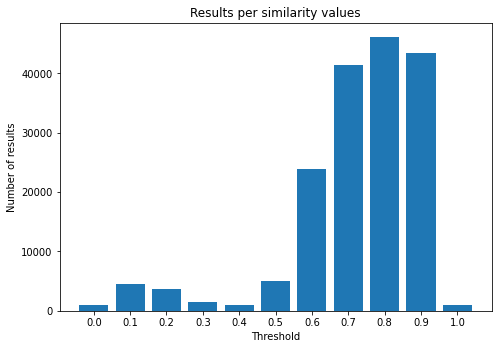

In [ ]:
x = []
y = []
for pair in NumSimilaritiesPerThreshold:
  x.append(str(pair[0]))
  y.append(pair[1])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = x
students = y
ax.bar(langs,students)
plt.xlabel('Threshold')
plt.ylabel('Number of results')
plt.title('Results per similarity values')
plt.show()